# Model fitting in Python

## Introduction 

Python offers a wide range of tools for fitting mathematical models to data. Here we will look at using Python to fit non-linear models to data using Least Squares (NLLS). 

You may want to have a look at [this Chapter](./20-ModelFitting.ipynb), and in particular, it NLLS section, and the lectures on [Model fitting](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/ModelFitting) and [NLLS](https://github.com/mhasoba/TheMulQuaBio/blob/master/content/lectures/NLLS) before proceeding.    

WE will use the `Lmfit` package, which provides a high-level interface to non-linear optimization and curve fitting problems for Python.

There are three main things that one needs in order to perform NLLS fitting succesfully in Python.
1. Data
2. Model specification
3. Initial values for parameters in the model

The image below summarizes how NLLS fitting works with these 3 entities.

![image](./graphics/lmfit_workflow.jpg)

We will use population growth rates as an example, as we did the [model fitting chapter](Model-Fitting-R-Population-Growth) (where we used R).

First let's import the necessary packages (you may need to install `lmfit` first).

In [1]:
from lmfit import Minimizer, Parameters, report_fit
import numpy as np
import matplotlib.pylab as plt

Now, create some artificial data:

In [2]:
t = np.arange(0, 24, 2)
N = np.array([32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000])

In [3]:
np.random.seed(1234) #Set random seed for reproducibility

N_rand = N*(1 + np.random.normal(scale = 0.1, size = len(N))) #Add some error to data

Here's what the data look like:

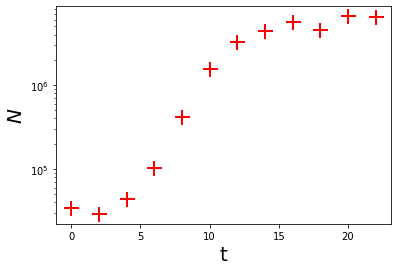

In [4]:
plt.plot(t, N_rand, 'r+', markersize = 15, markeredgewidth = 2, label = 'Data')
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$N$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])
plt.yscale('log')

## Fitting a Linear model to the data 

Lets start with the simplest case; a linear model. 

\begin{equation*}\label{eq:linear_model}
    N_t = at^3 + bt^2 + ct + d
\end{equation*} 

where $a$, $b$, $c$ and $d$, are phenomenological parameters.

### Using NLLS

In [5]:
#Create object for storing parameters
params_linear = Parameters()

#Add parameters and initial values to it
params_linear.add('a', value = 1)
params_linear.add('b', value = 1)
params_linear.add('c', value = 1)
params_linear.add('d', value = 1)

In [6]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_linear(params, t, data):
    """Calculate cubic growth and subtract data"""
    
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    
    #Cubic model
    model = v['a']*t**3 + v['b']*t**2 + v['c']*t + v['d']

    return model - data     #Return residuals

In [7]:
#Create a Minimizer object
minner = Minimizer(residuals_linear, params_linear, fcn_args=(t, np.log(N_rand)))

#Perform the minimization
fit_linear_NLLS = minner.minimize()

The variable `fit_linear` belongs to a class called [`MinimizerResult`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult), which include data such as status and error messages, fit statistics, and the updated (i.e., best-fit) parameters themselves in the params attribute. 

Now get the summary of the fit:

In [8]:
report_fit(fit_linear_NLLS)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 12
    # variables        = 4
    chi-square         = 1.68617886
    reduced chi-square = 0.21077236
    Akaike info crit   = -15.5493005
    Bayesian info crit = -13.6096739
[[Variables]]
    a: -0.00147820 +/- 5.3322e-04 (36.07%) (init = 1)
    b:  0.03687009 +/- 0.01787451 (48.48%) (init = 1)
    c:  0.14339899 +/- 0.16467922 (114.84%) (init = 1)
    d:  10.0545124 +/- 0.39977042 (3.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.984
    C(b, c) = -0.960
    C(a, c) =  0.900
    C(c, d) = -0.779
    C(b, d) =  0.621
    C(a, d) = -0.528


### Using OLS

`lmfit`'s purpose is not to fit linear models, although it is general enough to do so. Recall that a 3rd degree polynomial is a Lienar model, and it can be fitted using *Ordinary Least Squares*. You can easily do this  with the function `polyfit`. 

Let's try this for the same data.

In [9]:
fit_linear_OLS = np.polyfit(t, np.log(N_rand), 3) # degree = 3 as this is a cubic 

Now check the fitted coefficients: 

In [10]:
print(fit_linear_OLS)

[-1.47819938e-03  3.68700893e-02  1.43398989e-01  1.00545124e+01]


### Comparing the NLLS and OLS fits

Let's compare the the coefficients obtained using NLLS (using `lmfit`) vs using OLS (with `polyfit`) above. 

First have a another look at the NLLS result: 

In [11]:
fit_linear_NLLS.params

name,value,standard error,relative error,initial value,min,max,vary
a,-0.00147820,5.3322e-04,(36.07%),1,-inf,inf,True
b,0.03687009,0.01787451,(48.48%),1,-inf,inf,True
c,0.14339899,0.16467922,(114.84%),1,-inf,inf,True
d,10.0545124,0.39977042,(3.98%),1,-inf,inf,True


Now extract the just the estimated parameter values obtained with `lmfit` (it takes some effort as these are saved in a Python dictionary within the fitted model object):

In [12]:
par_dict = fit_linear_NLLS.params.valuesdict().values()

#Transform these into an array
par = np.array(list(par_dict))

#Check the difefrences in the the parameter values obtained with lmfit and polyfit
print(fit_linear_OLS - par)

[ 2.18245647e-12  2.18892265e-12  7.72548692e-13 -1.61293201e-11]


There are differences because NLLS is not an exact method. But these differences are *tiny*, showing that NLLS converges on pretty much the same solution as the (exact) OLS method.

Next, you can calculate the residuals of the fit: 

### Calculating the residuals, etc.

Once you have done the model fitting you can calculate the residuals:

In [13]:
#Construct the fitted polynomial equation
my_poly = np.poly1d(fit_linear_OLS)

#Compute predicted values
ypred = my_poly(t)

#Calculate residuals
residuals = ypred - np.log(N_rand)

The residuals can be then used to calculate BIC, AIC, etc, as you [learned previously](Model-Fitting-R-Comparing-Models).


#### Exercise

* We calculated the residuals above using the OLS fit of the cubic model to the data. Calculate the residuals for the NLLS fit of the same model to the data (i.e., using the `fit_linear_NLLS` object). 
    * *Hint*: To do this, you will need to first extract the coefficients, and then use the `residuals_linear` function that we created above.

## Fitting Non-linear models to the data

Now let's use `lmfit` to do what it was actually designed for: fitting non-linear mathematical models to data. We will fit the same two models that we fitted in the [Model Fitting Chapter](Model-Fitting-R-Population-Growth) (where we used R). 

### Logistic model fit

A classical, somewhat mechanistic model is the logistic growth equation:

\begin{equation*}
    N_t =   \frac{N_0  N_{max} e^{r t}}{N_{max} + N_0 (e^{r t} - 1)}
\end{equation*}

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_{max}$), and $N_{max}$ is carrying capacity (commonly denoted by $K$ in the ecological literature).

In [14]:
#Create object for parameter storing
params_logistic = Parameters()
params_logistic.add('N_0', value = N_rand[0])
params_logistic.add('N_max', value = N_rand[-1])
#Recall the value for growth rate obtained from a linear fit
params_logistic.add('r', value = 0.62)

In [15]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_logistic(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = np.log(v['N_0'] * v['N_max'] * np.exp(v['r']*t) / \
    (v['N_max'] + v['N_0'] * ( np.exp(v['r']*t) - 1 )))
    #Return residuals
    return model - data

In [16]:
#Create a Minimizer object
minner = Minimizer(residuals_logistic, params_logistic, fcn_args=(t, np.log(N_rand)))#Plug in the logged data.
#Perform the minimization
fit_logistic = minner.minimize(method = 'leastsq')

Note that I am choosing the least squares as the optimization method. A table with alternative fitting algorithms offered by lmfit can be found [here](https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods).

In [17]:
#Get summary of the fit
report_fit(fit_logistic)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 12
    # variables        = 3
    chi-square         = 2.19693074
    reduced chi-square = 0.24410342
    Akaike info crit   = -14.3741446
    Bayesian info crit = -12.9194246
[[Variables]]
    N_0:    13998.5739 +/- 4769.60185 (34.07%) (init = 34032.16)
    N_max:  7108406.32 +/- 2165947.53 (30.47%) (init = 6529216)
    r:      0.44848151 +/- 0.05161938 (11.51%) (init = 0.62)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, r)     = -0.807
    C(N_max, r)   = -0.448
    C(N_0, N_max) =  0.239


Where function evals, is the number of iterations needed to reach the minimum. The `report_fit` function also offers estimations of goodness of fit such as $\chi^2$, BIC and AIC. These are calculated as specified [here](https://lmfit.github.io/lmfit-py/fitting.html#akaike-and-bayesian-information-criteria). Finally, uncertainties of each parameter estimate, correlation levels between them are also calculated. Details and caveats about these values can be found [here](https://lmfit.github.io/lmfit-py/fitting.html#uncertainties-in-variable-parameters-and-their-correlations).

### Gompertz model

Another alternative is the Gompertz model, which has been used frequently in the literature to model bacterial growth

\begin{equation*}\label{eq:Gompertzlog}
     \log(N_t) =  N_0 + (N_{max} - N_0) e^{-e^{r_{max} \exp(1) \frac{t_{lag} - t}{(N_{max} - N_0) \log(10)} + 1}}
\end{equation*}

Here maximum growth rate ($r_{max}$) is the tangent to the inflection point, $t_{lag}$ is the x-axis intercept to this tangent (duration of the delay before the population starts growing exponentially) and $\log\left(\frac{N_{max}}{N_0}\right)$ is the asymptote of the log-transformed population growth trajectory, i.e., the log ratio of maximum population density $N_{max}$ (aka “carrying capacity”) and initial cell (Population) $N_0$ density.

In [18]:
#Create object for parameter storing
params_gompertz = Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
params_gompertz.add_many(('N_0', np.log(N_rand)[0] , True, 0, None, None, None),
                         ('N_max', np.log(N_rand)[-1], True, 0, None, None, None),
                         ('r_max', 0.62, True, None, None, None, None),
                         ('t_lag', 5, True, 0, None, None, None))#I see it in the graph


In [19]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_gompertz(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['N_0'] + (v['N_max'] - v['N_0']) * \
    np.exp(-np.exp(v['r_max'] * np.exp(1) * (v['t_lag'] - t) / \
                   ((v['N_max'] - v['N_0']) * np.log(10)) + 1))
    #Return residuals
    return model - data

In [20]:
#Create a Minimizer object
minner = Minimizer(residuals_gompertz, params_gompertz, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_gompertz = minner.minimize()

In [21]:
#Sumarize results
report_fit(fit_gompertz)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 12
    # variables        = 4
    chi-square         = 0.11350314
    reduced chi-square = 0.01418789
    Akaike info crit   = -47.9299775
    Bayesian info crit = -45.9903509
[[Variables]]
    N_0:    10.3910132 +/- 0.07901002 (0.76%) (init = 10.43506)
    N_max:  15.6520240 +/- 0.06730933 (0.43%) (init = 15.6918)
    r_max:  1.74097660 +/- 0.09837840 (5.65%) (init = 0.62)
    t_lag:  4.52049075 +/- 0.24729695 (5.47%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_max, t_lag) =  0.757
    C(N_0, t_lag)   =  0.581
    C(N_max, r_max) = -0.465
    C(N_max, t_lag) = -0.318
    C(N_0, N_max)   = -0.132
    C(N_0, r_max)   =  0.115


### Plot the results

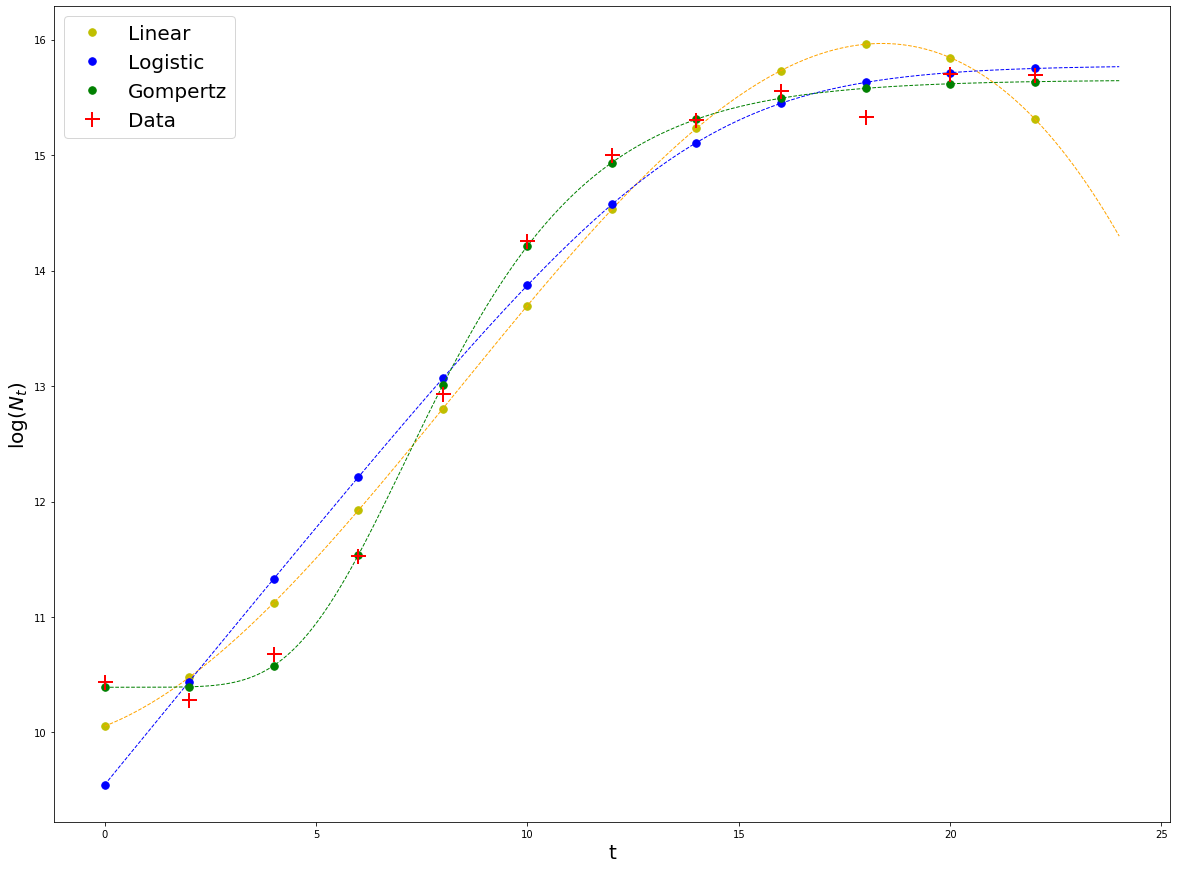

In [22]:
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear_NLLS.residual # These points lay on top of the theoretical fitted curve
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))#Create a vector of ones.
residual_smooth_linear = residuals_linear(fit_linear_NLLS.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])

## Exercise

The generalized Logistic model (also known as Richards' curve) is an extension of the logistic or sigmoid functions, allowing for more flexible S-shaped curves:

\begin{equation*}\label{eq:Hill}
    \log(N_t) = A + \frac{K - A}{1 + Q(e^{-Bt})^{1/\mu}}
\end{equation*}

Where $A$ is the lower asymptote, $K$ is the higher asymptote. If $A=0$ then $K$ is the carrying capacity. $B$ is the growth rate, $\mu >0$ affects near which asymptote maximum growth occurs. $Q$ is related to the value $N(0)$

Fit this model to the data using as initial values for the parameters: $A = 10$, $K = 16$, $Q = 0.5$, $B = 1$, $\mu = 0.1$, $T = 7.5$

In [23]:
#Define the parameter object
params_genlogistic = Parameters()
#Add parameters and initial values
params_genlogistic.add('A', value = 10, min = 0)
params_genlogistic.add('K', value = 16, min = 0)
params_genlogistic.add('Q', value = 0.5, min = 0)
params_genlogistic.add('B', value = 1, min = 0)
params_genlogistic.add('mu', value = 0.1, min = 0)
params_genlogistic.add('T', value = 7.5, min = 0)

In [24]:
#Define the model
def residuals_genlogistic(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['A'] + (v['K'] - v['A']) / \
    (1 + v['Q'] * np.exp(-v['B']*(t-v['T'])))**(1/v['mu'])
    #Return residuals
    return model - data

In [25]:
#Perform the fit
#Create a Minimizer object
minner = Minimizer(residuals_genlogistic, params_genlogistic, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_genlogistic = minner.minimize()

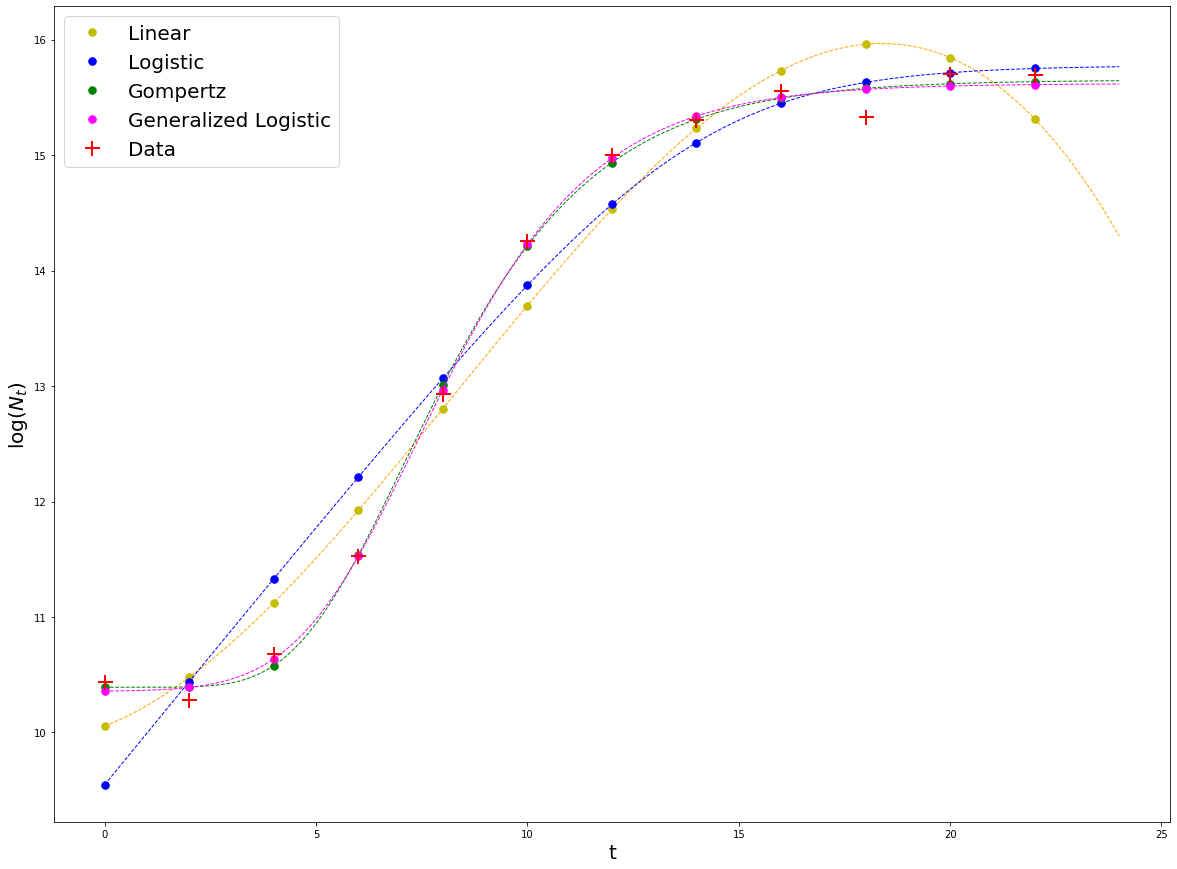

In [26]:
#Overlay the fit with the others
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear_NLLS.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear_NLLS.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Generalized logistic
result_genlogistic = np.log(N_rand) + fit_genlogistic.residual
plt.plot(t, result_genlogistic, '.', markerfacecolor = 'magenta', 
         markeredgecolor = 'magenta', markersize = 15, label = 'Generalized Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_genlogistic = residuals_genlogistic(fit_genlogistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_genlogistic + log_N_vec, 'magenta', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])

We can visually tell that the model that best fits the data is the Generalized Logistic model, closely followed by the Gompertz model. Does this mean that the Generalized Logistic model is a better model?
No. Generally, better models will be those that fit the data well, have less parameters, and these can be interpreted mechanistically. In these case, the Gomperz model fits the data almost as good as the Generalized Logistic (GL), but has less parameters, and these are more 'mechanistic' than the ones in GL, so it is clearly better.

## Readings & Resources

* If you choose Python for the model fitting component of your workflow, you will probably want to use `lmfit`. 
Look up documentation/help on submodules `minimize`, `Parameters`, `Parameter`, and `report_fit` in particular. 
    * Also *Have a look through* <http://lmfit.github.io/lmfit-py>, especially <http://lmfit.github.io/lmfit-py/fitting.html#minimize> . 

* You will have to install `lmfit` using `pip` or `easy_install`  (use sudo mode). *Lots of examples of using lmfit can be found online (for example, by searching for "lmfit examples"!)*.